In [1]:
import json
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
fh_mint = "#00B1AC"
plt.rcParams.update({'font.size': 22})
channels_of_interest = ['F3-A2', 'F4-A1', 'C3-A2', 'C4-A1']

In [3]:
cohort_mapping = json.load(open("../../output/annotations/nikitin/cohort_mapping.json", "r"))

# base functions

In [4]:
def overlap(spindle_df, sleepstages):
    sleepstages = np.repeat(sleepstages, 2)  # transform sleepstages to half epoches
    sleepstages = sleepstages == 'N2'
    spindle_centers = (spindle_df[['start', 'end']].sum(axis=1) // 2).astype(int).values
    if len(sleepstages) < max(spindle_centers) // 15:
        print(f'Warning: sleepstages shorter than spindles, '
              f'ignoring {sum(spindle_centers // 15 >= len(sleepstages))} spindles')
    idx = [sleepstages[center // 15]
           if center // 15 < len(sleepstages) else False
           for center in spindle_centers]
    return spindle_df[idx]


def merge_and_filter_spindles(spindle_df, merge_dur=0.3, merge_dist=0.1, min_dur=0.3, max_dur=2.5):
    spindle_df.sort_values('start', inplace=True)
    durations = (spindle_df['end'] - spindle_df['start']).values
    distances = spindle_df['start'].iloc[1:].values - spindle_df['end'].iloc[:-1].values
    to_merge = (durations[:-1] < merge_dur) & (durations[1:] < merge_dur) & (distances < merge_dist)
    spindle_df.loc[np.r_[to_merge, False], 'end'] = spindle_df.loc[np.r_[False, to_merge], 'end'].values
    spindle_df = spindle_df[~np.r_[False, to_merge]]

    durations = spindle_df['end'] - spindle_df['start']
    to_filter = (durations < min_dur) | (durations > max_dur)
    spindle_df = spindle_df[~to_filter]

    print(f'Merged {np.sum(to_merge)} spindles, filtered {np.sum(to_filter)} spindles')

    return spindle_df


def plot_figure_1(bp_spindles_dfs, hc_spindles_dfs, characteristics, save_path=None):
    n_channels = len(channels_of_interest)
    _, ax = plt.subplots(1, 1, figsize=(1 + 2 * n_channels, 10))
    ch_keys = list(sorted(bp_spindles_dfs.keys()))
    assert all(c in ch_keys for c in channels_of_interest), f"channels_of_interest not in keys: {ch_keys}"
    for i, key in enumerate(channels_of_interest):
        if bp_spindles_dfs[key].size == 0:
            continue

        spm_BP_pred = []
        for file in [k for k, v in cohort_mapping.items() if v == 'bp']:
            spindles_BP_pred = (
                bp_spindles_dfs[key]
                .query(f"`frequency` > 13 and `file` == @file")[["start", "end"]]
                .values
            )
            spm_BP_pred.append(len(spindles_BP_pred) / characteristics[file])
        spm_HC_pred = []
        for file in [k for k, v in cohort_mapping.items() if v == 'hc']:
            spindles_HC_pred = (
                hc_spindles_dfs[key]
                .query(f"`frequency` > 13 and `file` == @file")[["start", "end"]]
                .values
            )
            spm_HC_pred.append(len(spindles_HC_pred) / characteristics[file])
        spm_BP_pred = np.array(spm_BP_pred)
        spm_HC_pred = np.array(spm_HC_pred)

        bp = plt.boxplot(
            [spm_BP_pred, spm_HC_pred],
            patch_artist=True,
            tick_labels=["BP", "HC"],
            positions=[3 * i, 3 * i + 1],
            widths=1,
        )

        plt.text(
            3 * i,
            bp["whiskers"][1].get_ydata()[1] + 0.25,
            f"{spm_BP_pred.mean():.2f} ± {spm_BP_pred.std():.2f}",
            size=14,
            ha="center",
            c=fh_mint,
        )
        plt.text(
            3 * i + 1,
            bp["whiskers"][3].get_ydata()[1] + 0.25,
            f"{spm_HC_pred.mean():.2f} ± {spm_HC_pred.std():.2f}",
            size=14,
            ha="center",
            c="black",
        )

        colors = [fh_mint, "black", fh_mint, "black"]
        patterns = ["/", "\\", "/", "\\"]
        for patch, color, pattern in zip(bp["boxes"], colors, patterns):
            patch.set_facecolor(color)
            patch.set_hatch(pattern)
            patch.set_edgecolor("white")
        for median_artist in bp["medians"]:
            median_artist.set_linewidth(2)

    bp["boxes"][0].set_label("BP")
    bp["boxes"][1].set_label("HC")
    plt.legend(bbox_to_anchor=(1, .5), loc="center left")  #, fontsize=12)

    plt.xticks(np.linspace(0.5, 3 * (n_channels - 1) + 0.5, n_channels), channels_of_interest)
    plt.xlim((-1.2, (n_channels - 1) * 3 + 2.2))
    plt.ylim((0, plt.ylim()[1] + 0.5))

    plt.xlabel("Channel")
    plt.ylabel("SPM")
    plt.grid(axis="x")
    if save_path:
        plt.savefig(save_path)
    plt.show()

# predicted spindles (filtered by predicted sleep stages)

In [5]:
# load sleepstages
pred_path = "../../output/annotations/nikitin/pred_sleep_stages/"

pred_sleep_stages = {}
for file in os.listdir(pred_path):
    if file.endswith('_sleepstages.txt'):
        s_stages = np.loadtxt(pred_path + file, dtype=str, delimiter=" ")
        s_stages = ['N2' if s == '2' else s for s in s_stages]
        pred_sleep_stages[file.split("_")[0]] = s_stages

pred_char = {s_id: sum([1 for s in stages if s == 'N2']) / 2 for s_id, stages in pred_sleep_stages.items()}

In [6]:
# load spindles
pred_path = "../../output/annotations/nikitin/pred_spindles_w_pred_stages/"
pred_files = [f for f in os.listdir(pred_path) if f.endswith('.npz')]

f_ids = [f.split("_")[0] for f in pred_files]

# create empty Dataframe for each channel
BP_pred = {name: pd.DataFrame() for name in channels_of_interest}
HC_pred = {name: pd.DataFrame() for name in channels_of_interest}
columns = ['start', 'end', 'frequency', 'amplitude ptp', 'amplitude hilbert']

# add contents of each file to dataframes
for f_id, f in zip(f_ids, pred_files):
    pred_data = np.load(pred_path + f)
    for ch in [f'EEG {c}' for c in channels_of_interest]:
        df = pd.DataFrame(pred_data[f"{f_id}_{ch}_fold-0_agg"], columns=columns)
        df["file"] = f_id

        df = overlap(df, pred_sleep_stages[f_id])
        df = merge_and_filter_spindles(df)

        if cohort_mapping[f_id] == 'bp':
            BP_pred[ch.split(" ", 1)[1]] = pd.concat([BP_pred[ch.split(" ", 1)[1]], df], axis=0,
                                                     ignore_index=True)
        else:
            HC_pred[ch.split(" ", 1)[1]] = pd.concat([HC_pred[ch.split(" ", 1)[1]], df], axis=0,
                                                     ignore_index=True)

Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filter

spm prediction BP: 5.53 ± 3.20
spm prediction HC: 7.17 ± 2.78


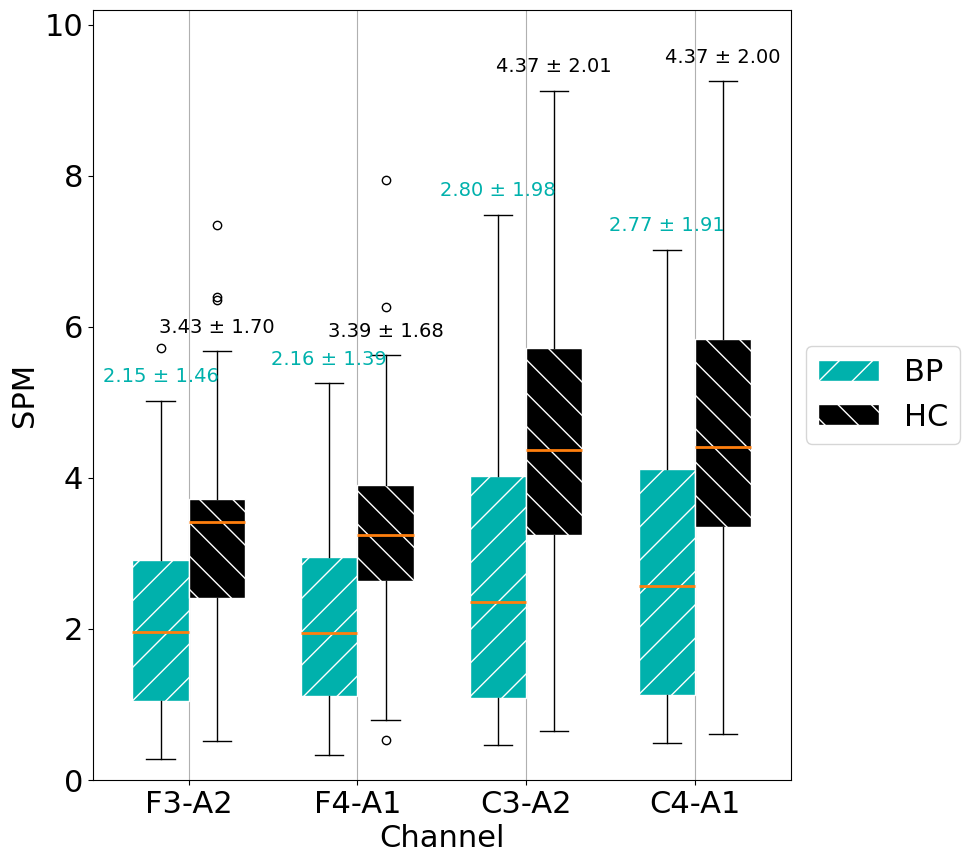

In [7]:
# plot
spms_per_recording_pred_bp = []
spms_per_recording_pred_hc = []
for file in cohort_mapping.keys():
    if cohort_mapping[file] == 'bp':
        spindles_pred = BP_pred['C3-A2'].query(f"`file` == @file")[["start", "end"]].values
        spms_per_recording_pred_bp.append(len(spindles_pred) / pred_char[file])
    else:
        spindles_pred = HC_pred['C3-A2'].query(f"`file` == @file")[["start", "end"]].values
        spms_per_recording_pred_hc.append(len(spindles_pred) / pred_char[file])
print(f"spm prediction BP: {np.mean(spms_per_recording_pred_bp):.2f} ± {np.std(spms_per_recording_pred_bp):.2f}")
print(f"spm prediction HC: {np.mean(spms_per_recording_pred_hc):.2f} ± {np.std(spms_per_recording_pred_hc):.2f}")

plot_figure_1(BP_pred, HC_pred, pred_char, "figures/nikitin-figure-1.svg")

# GT spindles (filtered by GT sleep stages)

In [8]:
# set folders
pred_path = "../../output/annotations/nikitin/gt_spindles/combined_spindles.npz"
gt_char_path = "../../output/annotations/nikitin/gt_sleep_stages/"

In [9]:
# load data from predicted spindles
pred_data = np.load(pred_path)
f_ids = set([key.split("_")[0] for key in pred_data.keys() if key != 'header'])
channels = set([key.split("_")[1] for key in pred_data.keys() if key != 'header'])
channels = [ch for ch in channels if 'EEG' in ch]

# create empty Dataframe for each channel
BP_pred = {name.split(" ", 1)[1]: pd.DataFrame() for name in channels}
HC_pred = {name.split(" ", 1)[1]: pd.DataFrame() for name in channels}

# load sleep characteristics for each file
gt_sleep_stages = {}
for file in os.listdir(gt_char_path):
    with open(os.path.join(gt_char_path, file), 'r') as f:
        gt_stages = f.read().split(' ')
    gt_stages = ["N2" if s == '2' else s for s in gt_stages]
    gt_sleep_stages[file.rsplit(".", 1)[0].split("_")[0]] = gt_stages

gt_char = {}
for key in gt_sleep_stages.keys():
    gt_char[key] = sum([1 for s in gt_sleep_stages[key] if s == "N2"]) / 2

# add contents of each file to dataframes
for f_id in f_ids:
    for name in channels:
        columns = ['start', 'end', 'frequency', 'amplitude ptp', 'amplitude hilbert']
        df = pd.DataFrame(pred_data[f"{f_id}_{name}"], columns=columns)
        df["file"] = f_id

        df = overlap(df, gt_sleep_stages[f_id])
        # df = merge_and_filter_spindles(df)

        if cohort_mapping[f_id] == 'bp':
            BP_pred[name.split(" ", 1)[1]] = pd.concat([BP_pred[name.split(" ", 1)[1]], df], axis=0,
                                                       ignore_index=True)
        else:
            HC_pred[name.split(" ", 1)[1]] = pd.concat([HC_pred[name.split(" ", 1)[1]], df], axis=0,
                                                       ignore_index=True)

BP_pred = {k: v.rename(columns={'avg_frequency_zero_cross': 'frequency'}) for k, v in BP_pred.items()}
HC_pred = {k: v.rename(columns={'avg_frequency_zero_cross': 'frequency'}) for k, v in HC_pred.items()}

spm GT BP: 3.49 ± 2.04
spm GT HC: 4.23 ± 1.79
spm prediction BP: 5.53 ± 3.20
spm prediction HC: 7.17 ± 2.78


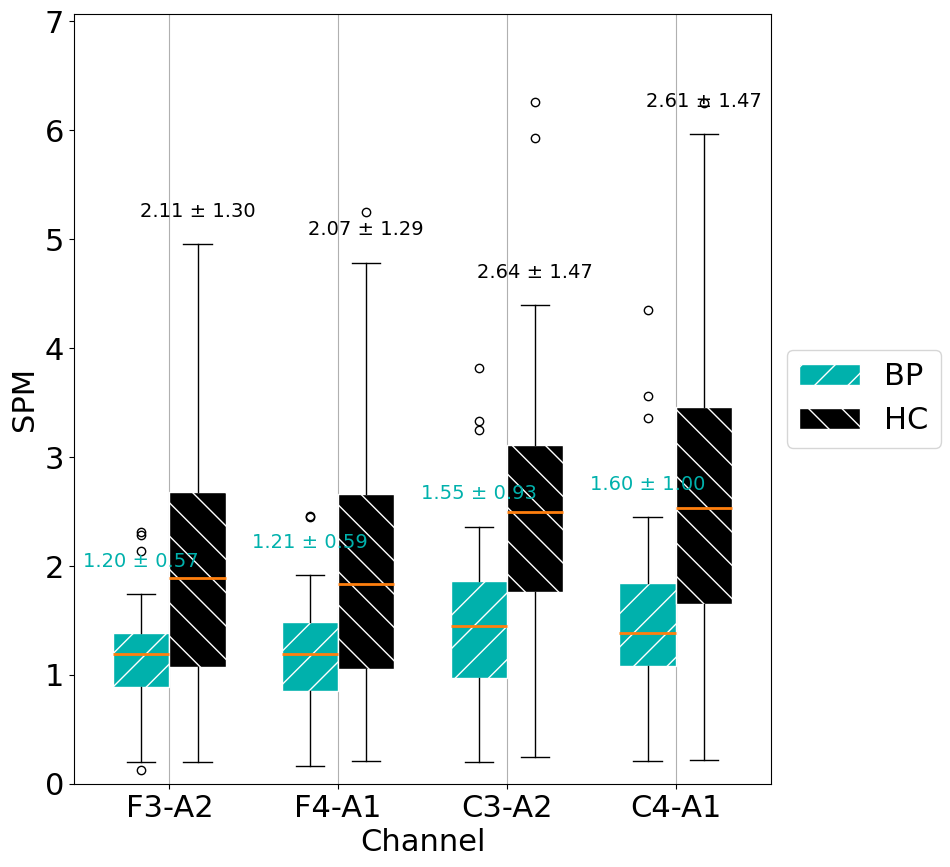

In [10]:
# plot
spms_per_recording_gt_bp = []
spms_per_recording_gt_hc = []
for file in f_ids:
    if cohort_mapping[file] == 'bp':
        spindles_gt = BP_pred['C3-A2'].query(f"`file` == @file")[["start", "end"]].values
        spms_per_recording_gt_bp.append(len(spindles_gt) / gt_char[file])
    else:
        spindles_gt = HC_pred['C3-A2'].query(f"`file` == @file")[["start", "end"]].values
        spms_per_recording_gt_hc.append(len(spindles_gt) / gt_char[file])
print(f"spm GT BP: {np.mean(spms_per_recording_gt_bp):.2f} ± {np.std(spms_per_recording_gt_bp):.2f}")
print(f"spm GT HC: {np.mean(spms_per_recording_gt_hc):.2f} ± {np.std(spms_per_recording_gt_hc):.2f}")

print(f"spm prediction BP: {np.mean(spms_per_recording_pred_bp):.2f} ± {np.std(spms_per_recording_pred_bp):.2f}")
print(f"spm prediction HC: {np.mean(spms_per_recording_pred_hc):.2f} ± {np.std(spms_per_recording_pred_hc):.2f}")

plot_figure_1(BP_pred, HC_pred, gt_char)